# Lab 2: Markov Decision Process (MDP)


## The Maze


Let's look back at the example maze from Lab 1.
```
########
#  G#G #
# # ## #
# @ G  #
########
```

In the example, what are the **actions**?

How does the environment respond to actions? What are the **transitions**?

How do we encode the player's goal? What would be the **reward**?

Are there different options? What are their advantages?


## The MDP


The **Markov Decision Process** (MDP) is commonly used to model single-agent environments with perfect observations. Its main parts are:

$\mathcal S$ - state space

$\mathcal A$ - action space

$T$ - transition function

$R$ - reward function

State space $\mathcal S$ is an enumeration of all possible states in the problem.
- What if there are infinite possible states?

Action space $\mathcal A$ define the possible actions.
- What about infinite action space? (e.g., $accelerate(0.23)$)
- Can it be state dependent?

Transition function $T$ defines what happens when applying an action $a$ in a state $s$.
- When deterministic: $T: \mathcal S \times \mathcal A \rightarrow \mathcal S$.
- When stochastic: $T(s, a, s') = Pr\{s' | s, a\}$.

Similarly, the reward function $R(s, a, s')$ defines the rewards.

**Note.** The lectures define the *dynamics* of the MDP concisely as follows:
$ p(s', r | s, a) \leftarrow Pr(s', r | s, a) $

## Case study: Atari - Pong

You all know Pong. Players control paddles, bouncing a ball around and trying to score.

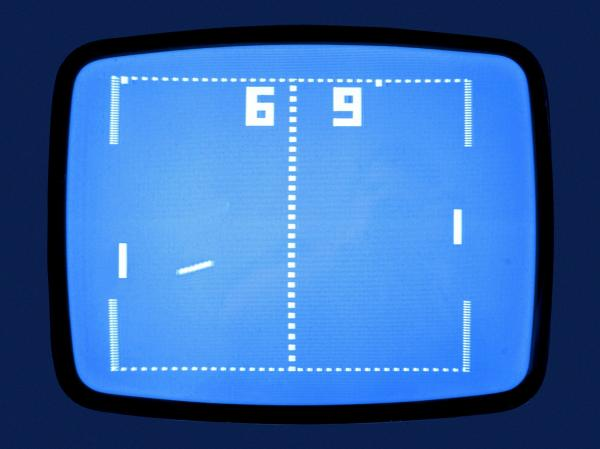

What would be the **state** in this case?
- What are the different options?
- Can we use the internal state of the game?

- What about a general representation for all possible Atari games?
- What is the **Markov property** and would it be preserved?

Is the representation finite?


Let's assume the player controls only a single paddle. What are the **actions**?

What are the **transitions** and **rewards**?
- What if the game is really complex or we cannot access its internal state? (i.e., we have only a model)
- Advanced RL methods: [Reinforcement Learning: An Introduction](http://incompleteideas.net/book/the-book.html) book.

## Practice Time

### Small numpy cheatsheet

In [1]:
import numpy as np

In [2]:
x = np.zeros((2,3,3))  # Tensor
print(x, x.shape)

[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]] (2, 3, 3)


In [3]:
x[0,1,2] = 1
print(x)  # Where will the value be put?

[[[0. 0. 0.]
  [0. 0. 1.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]


In [4]:
print(x[1:, 1:2, :].shape)  # Try to predict the shape!

(1, 1, 3)


### The Maze again

Bellow is the good old Maze. It's the same as in Lab 1.

In [5]:
from copy import deepcopy
from typing import List, Dict, Tuple, Set

Action = str  # Type alias


class State:
    def __init__(self, maze_rows: List[str]) -> None:
        self._maze_rows = [list(row) for row in maze_rows]

        # Make sure the maze has a rectangular shape, and has a proper boundary.
        assert all(len(row) == self.num_cols() for row in self._maze_rows)
        assert set(self._maze_rows[0]) == {"#"} and set(self._maze_rows[-1]) == {"#"}
        assert all(row[0] == "#" and row[-1] == "#" for row in self._maze_rows)

    def actions(self) -> List[Action]:
        """
        :return: list of available actions
        """
        return [
            "u",  # Up
            "d",  # Down
            "l",  # Left
            "r",  # Right
        ]

    def apply(self, action: Action) -> None:
        """
        Change current state by applying an action.
        """

        assert action in self.actions()
        i, j = self.current_position()

        # Maze rows is a List, this makes a reference in Python, not a copy.
        m = self._maze_rows

        # These bound checks work because we made sure that the whole maze is
        # delimited with char #   -- otherwise we would have to make much more
        # complicated if statements! This is a common implementation trick, used
        # for example in Chess or Go engines.
        if action == "u" and m[i - 1][j] != "#":
            m[i][j], m[i - 1][j] = " ", "@"
        elif action == "d" and m[i + 1][j] != "#":
            m[i][j], m[i + 1][j] = " ", "@"
        elif action == "l" and m[i][j - 1] != "#":
            m[i][j], m[i][j - 1] = " ", "@"
        elif action == "r" and m[i][j + 1] != "#":
            m[i][j], m[i][j + 1] = " ", "@"

    def copy(self) -> "State":
        """
        Make a copy of the current state.
        """
        return State(deepcopy(self._maze_rows))

    # -- Maze specific methods ---------------------------------------------------

    def num_rows(self) -> int:
        return len(self._maze_rows)

    def num_cols(self) -> int:
        return len(self._maze_rows[0])

    def current_position(self) -> Tuple[int, int]:
        # Find current position: it is denoted using an @ sign.
        for i in range(self.num_rows()):
            for j in range(self.num_cols()):
                if self._maze_rows[i][j] == "@":
                    return i, j
        raise RuntimeError(
            "Invalid maze: current position not found in: " + "\n".join(self._maze_rows)
        )

    def captures_gold(self, action: Action) -> bool:
        i, j = self.current_position()
        m = self._maze_rows
        return (
            (action == "u" and m[i - 1][j] == "G")
            or (action == "d" and m[i + 1][j] == "G")
            or (action == "l" and m[i][j - 1] == "G")
            or (action == "r" and m[i][j + 1] == "G")
        )

    def has_any_gold(self) -> bool:
        for i in range(self.num_rows()):
            for j in range(self.num_cols()):
                if self._maze_rows[i][j] == "G":
                    return True
        return False

    # -- Helper methods ----------------------------------------------------------

    def __str__(self) -> str:
        return "\n".join(["".join(row) for row in self._maze_rows])

    def __eq__(self, other) -> bool:
        return self._maze_rows == other._maze_rows

    def __hash__(self) -> int:
        return hash(str(self))

    def __repr__(self) -> str:
        return str(self)

In the last lab, we created a function to get all possible transitions for further visualization.

Let's change it to get all possible *states* and *transitions* between them, along with the *reward*. Let the reward be $1$ if any gold is consumed, otherwise $-0.1$. The small negative reward is common incentive to find the shortest solution. Other choices of negative reward would be fine as well -- the choice of -0.1 is arbitrary.

In [6]:
Transition = Tuple[int, int, Action, float]  # transition (from_idx, to_idx, action, reward)


def get_all_transitions(init_state: State) -> Tuple[List[State], Set[Transition]]:
    states = [init_state]  # List of unique States. We use list to index them with a number.
    transitions = set()    # Set of transitions.
    opened = [0]           # List of open state indices that we did not go through yet.

    while len(opened) > 0:
        from_idx = opened.pop()
        state = states[from_idx]

        for action in state.actions():
            next_state = state.copy()
            next_state.apply(action)

            reward = 1 if state.captures_gold(action) else -0.1

            if next_state in states:
                # State was visited.
                to_idx = states.index(next_state)
            else:
                # Not visited yet, add to open.
                states.append(next_state)
                to_idx = len(states) - 1
                opened.append(to_idx)

            transitions.add((from_idx, to_idx, action, reward))

    return states, transitions

*Bonus question*: What is the time complexity of the above algorithm? Can we improve it?

## Solving the Maze as an MDP



We'll use `pymdptoolbox` library ([code](https://github.com/sawcordwell/pymdptoolbox) / [docs](https://pymdptoolbox.readthedocs.io/en/latest/)). Let's install it and import it.

In [7]:
!pip install pymdptoolbox
import mdptoolbox

---
Let's define a sample maze and get its states and transitions between them.



In [8]:
maze3 = State(["########",
               "#  G#G #",
               "# # ## #",
               "#@  G  #",
               "########"])

states, transitions = get_all_transitions(maze3)

print(f"There are {len(states)} states and total of {len(transitions)} transitions.")

There are 67 states and total of 268 transitions.


In [9]:
import graphviz


def viz_state_space(mdp: Tuple[List[State], set]) -> graphviz.Digraph:
    states, edges = mdp
    graph = graphviz.Digraph(strict=False, engine="fdp")  # Allow multi-edges
    graph.node_attr["fontname"] = "monospace"

    for i, s in enumerate(states):
        style_args = dict(color="red", fontcolor="red") if i == 0 else dict()
        graph.node(str(s), **style_args)

    for i, j, action, reward in edges:
        from_state, to_state = states[i], states[j]
        graph.edge(
            str(from_state), str(to_state), key=action, label=f"{action}: {reward}"
        )

    return graph

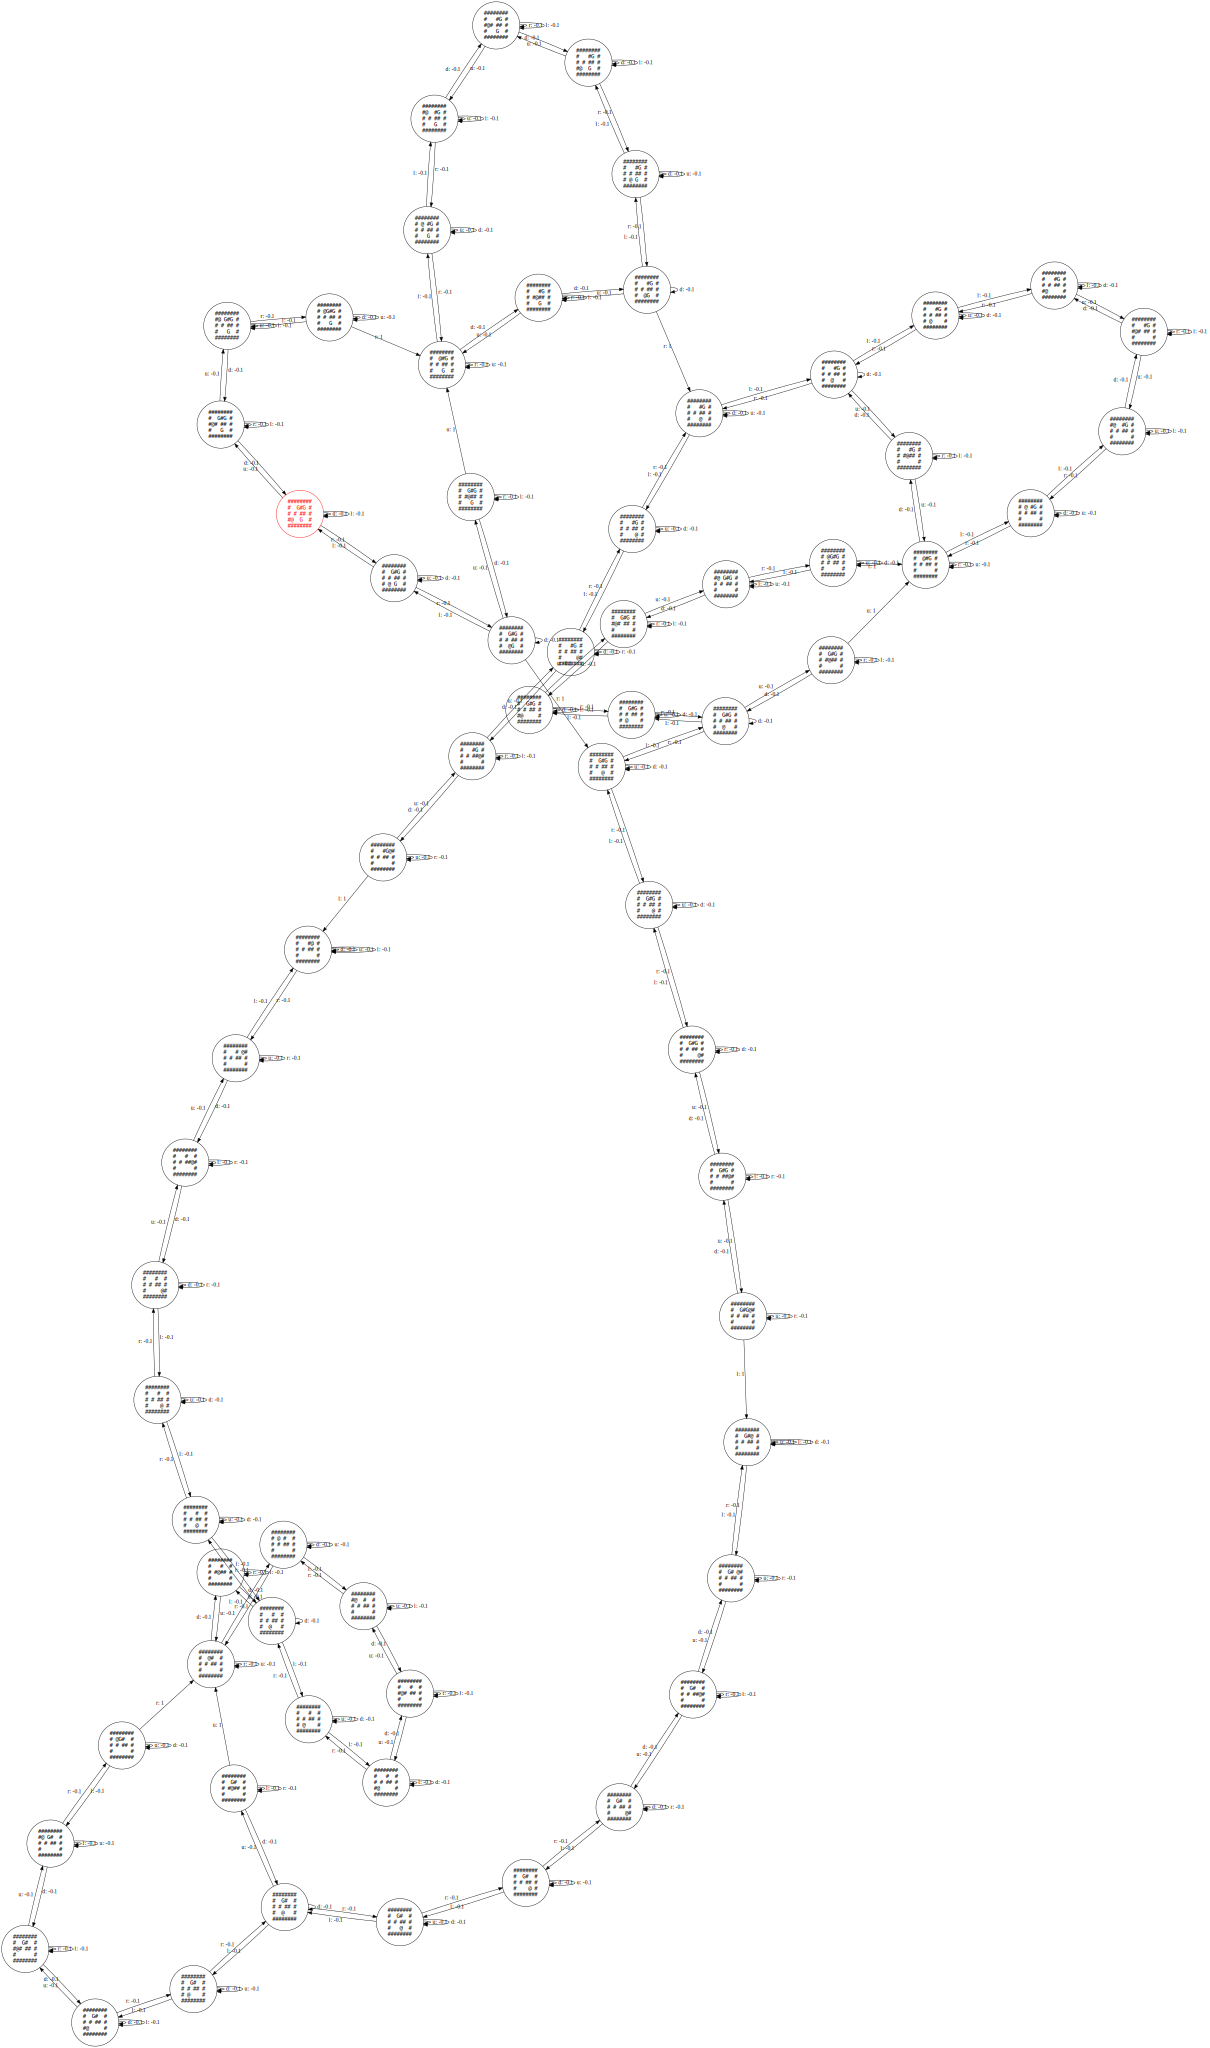

In [10]:
from IPython.display import display, HTML

# Make sure the generated graph fits into view... it can get quite big!
display(HTML("<style>svg{width:800px !important;height:600px !important;</style>"))

viz_state_space(get_all_transitions(maze3))

The `pymdptoolbox` library needs the MDP - states, actions, transitions and rewards in form of matrices. If needed, look at the documentation for [mdptoolbox.mdp.MDP](https://pymdptoolbox.readthedocs.io/en/latest/api/mdp.html#mdptoolbox.mdp.MDP).

The transitions should be a tensor of shape $(A, S, S)$, where $A, S$ are the sizes of action and state spaces. The matrix describes the transition function for each action $a$ and states $s_i, s_j$. Since we are in deterministic environment, the matrix will be sparse with either 0s or 1s.

Let's transform these states and transitions into the matrix.


## Task 1: Fill the transition matrix


Implement the following method that fills the matrix such that `T[a,i,j] = 1` iff there exists a transition from $s_i$ to $s_j$ with action $a$, else the probability is zero.

In [11]:
def transition_matrix(actions: List[Action],
                      states: List[State],
                      transitions: List[Transition]) -> np.array:

    T = np.zeros((len(actions), len(states), len(states)))
    for from_idx, to_idx, action, reward in transitions:
      action_id = actions.index(action)
      T[action_id, from_idx, to_idx] = 1
    return T
    # raise NotImplementedError


Good. Let's now get a reward matrix. It's shape should be $(S, A)$ and contain rewards for $r(s, a)$ function. We've already defined the rewards in the transitions, so let's use it.

## Task 2: Fill the reward matrix

Implement the following method that fills the matrix such that `R[i,a] = 1` iff a gold is consumed starting at $s_i$ with action $a$, else -0.1.

In [12]:
def reward_matrix(actions: List[Action],
                  states: List[State],
                  transitions: List[Transition]) -> np.array:

    R = np.zeros((len(actions), len(states), len(states)))
    for from_indx, to_indx, action, reward in transitions:
        action_id = actions.index(action)
        R[action_id, from_indx, to_indx] = reward

    return R
    # raise NotImplementedError


Well done. Now, let's get the matrices and look at them.

In [13]:
actions = maze3.actions()[:]
T = transition_matrix(actions, states, transitions)
R = reward_matrix(actions, states, transitions)

print("T:", T.shape)
print(T)
print("\nR:", R.shape)
print(R)

T: (4, 67, 67)
[[[0. 1. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 1. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 1. 0.]
  [0. 0. 0. ... 0. 0. 1.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 1. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 1.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 1. 0.]
  [0. 0. 0. ... 0. 1. 0.]]

 [[0. 0. 1. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 1.]
  [0. 0. 0. ... 0. 0. 0.]]]

R: (4, 67, 67)
[[[ 0.  -0.1  0.  ...  0.   0.   0. ]
  [ 0.   0.   0.  ...  0.  -0.1  0. ]
  [ 0.   0.  -0.1 ...  0.   0.   0. ]
  ...
  [ 0.   0.   0.  ...  0.   0.   0. ]
  [ 0.   0.   0.  ...  0.  -0.1  0. ]
  [ 0.   0.   0.  ...  0.   0.  -0.1]]

 [[-0.1  0.   0.  ...  0.   0.   0. ]
  [-0.1  0.   0.  ...  0.   0.   0. ]
 

## Task 3: Find optimal policy for all states

From the `mdptoolbox` let's  choose a *value iteration* algorithm and run it. For now, it suffices to say it returns the optimal policy and value function.

In [1]:
# We will implement value iteration algorithm later in the labs ourselves.
# For now, we just use this library to demonstrate the algorithm.
mdp = mdptoolbox.mdp.ValueIteration(T, R,
                                    # You will learn about these parameters later.
                                    discount=0.99, epsilon=0.2, max_iter=1000)
mdp.run()

# Get the optimal policy.
pi = mdp.policy

print("π:", pi)

NameError: name 'mdptoolbox' is not defined

Cool. Unlike BFS/DFS algorithms that searches for a way from initial state to a goal, the policy tells us an optimal action for **any** situation!




Now, let's look at some states and what is the optimal action.


In [43]:
# Let's map action ids to action strings.
pi_a = [actions[a_id] for a_id in pi]

maze = maze3.copy()
state_idx = states.index(maze)   # Find the state id.
action = pi_a[state_idx]         # Optimal action id.

print(maze)
print(action)

########
#  G#G #
# # ## #
#@  G  #
########
u


Finally, let's follow the policy from the initial state and print its route. Let's see what happens.

In [44]:
maze = maze3.copy()

while maze.has_any_gold():
    state_idx = states.index(maze)
    optimal_action = pi_a[state_idx]

    print(maze)
    print(optimal_action)
    print("\n")

    maze.apply(optimal_action)

print(maze)

########
#  G#G #
# # ## #
#@  G  #
########
u


########
#  G#G #
#@# ## #
#   G  #
########
u


########
#@ G#G #
# # ## #
#   G  #
########
r


########
# @G#G #
# # ## #
#   G  #
########
r


########
#  @#G #
# # ## #
#   G  #
########
d


########
#   #G #
# #@## #
#   G  #
########
d


########
#   #G #
# # ## #
#  @G  #
########
r


########
#   #G #
# # ## #
#   @  #
########
r


########
#   #G #
# # ## #
#    @ #
########
r


########
#   #G #
# # ## #
#     @#
########
u


########
#   #G #
# # ##@#
#      #
########
u


########
#   #G@#
# # ## #
#      #
########
l


########
#   #@ #
# # ## #
#      #
########


It grabs all the gold! Good job!